In [ ]:
# ================== 1. Import ==================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import time, os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(">>> Đang sử dụng:", device)
if device.type == "cuda":
    print(">>> GPU:", torch.cuda.get_device_name(0))

# ================== 2. Data ==================
train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dir = "dataset/images/train"
val_dir   = "dataset/images/val"
test_dir  = "dataset/test"

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir,   transform=test_transform)
test_dataset  = datasets.ImageFolder(test_dir,  transform=test_transform)

class_names = train_dataset.classes
print("Class order:", class_names)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# ================== 3. Model ==================
model = models.efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# ================== 4. Training ==================
best_acc, patience, trigger = 0.0, 5, 0
for epoch in range(50):
    start = time.time()

    # --- Train ---
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        train_correct += (out.argmax(1) == y).sum().item()
        train_total += y.size(0)

    train_loss /= len(train_dataset)
    train_acc = train_correct / train_total

    # --- Validation ---
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item() * x.size(0)
            val_correct += (out.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss /= len(val_dataset)
    val_acc = val_correct / val_total
    scheduler.step()

    print(f"Epoch {epoch+1:02d} | Train {train_loss:.4f}/{train_acc:.4f} | "
          f"Val {val_loss:.4f}/{val_acc:.4f} | Time {time.time()-start:.1f}s")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Saved new best model")
        trigger = 0
    else:
        trigger += 1
        if trigger >= patience:
            print("⏹ Early stopping")
            break

print("Best Val Acc:", best_acc)   

SyntaxError: expected 'else' after 'if' expression (4253885151.py, line 15)

Classification Report:
               precision    recall  f1-score   support

 empty_pallet       1.00      1.00      1.00         2
loaded_pallet       1.00      1.00      1.00         2
      nothing       1.00      1.00      1.00         1

     accuracy                           1.00         5
    macro avg       1.00      1.00      1.00         5
 weighted avg       1.00      1.00      1.00         5



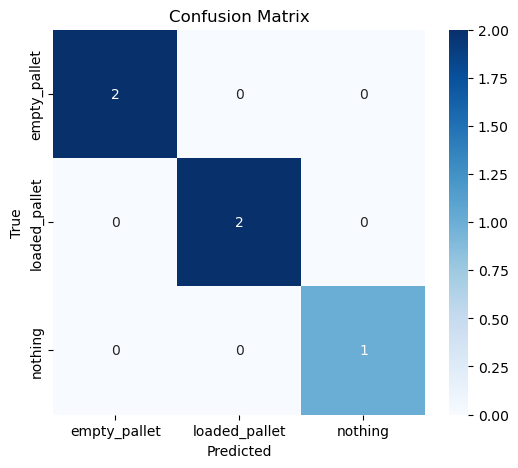

In [19]:
# ================== 5. Evaluation on Test set ==================
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        preds = out.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [13]:
# ================== 6. Inference ==================
transform_infer = test_transform  # phải giống test transform

def predict_image(path, topk=3):
    img = Image.open(path).convert("RGB")
    x = transform_infer(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0]
        top_probs, top_idxs = probs.topk(topk)
    results = [(class_names[i], float(top_probs[j])) for j,i in enumerate(top_idxs)]
    return results[0], results  # (best, top-k list)

def show_prediction(path):
    best, topk = predict_image(path)
    img = Image.open(path).convert("RGB")
    plt.imshow(img)
    plt.title(f"Pred: {best[0]} ({best[1]:.2f})")
    plt.axis("off")
    plt.show()
    print("Top-k:", topk)

# Ví dụ test
best, topk = predict_image(r"d:\LAB\213.jpg")
print("Predicted:", best)
print("Top-k:", topk)

#show_prediction("dataset/test/0030.jpg")

Predicted: ('nothing', 0.38667386770248413)
Top-k: [('nothing', 0.38667386770248413), ('empty_pallet', 0.3156278431415558), ('loaded_pallet', 0.29769831895828247)]
